In [1]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
## Warning suppression to keep console clean
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)
pd.options.mode.chained_assignment = None

# Loading metadata

In [3]:
os.chdir('/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA')

In [4]:
meta_filepath = "data/01-raw/case_metadata.csv"
sample_loc_filepath = "data/01-raw/cellbender_output_loc.csv"

meta = pd.read_csv(meta_filepath)
sample_loc = pd.read_csv(sample_loc_filepath)


In [5]:
# correct spacing issue
meta.columns = meta.columns.str.replace(' ', '')
meta.columns.values

meta.loc[:, meta.columns != 'notes'] = meta.loc[:, meta.columns != 'notes'].applymap(lambda x: x.replace(' ', '') if isinstance(x, str) else x)

In [6]:
## Isolating the BAL Samples
sample_loc_bal = sample_loc[sample_loc['sample_name'].str.contains("BAL") | sample_loc['sample_name'].isin(["RZ725_Pool4", "RZ725_Pool5", "RZ734_Pool_1", "RZ734_Pool_2", "RZ734_Pool_3"])]
sample_loc_bal = sample_loc_bal.reset_index(drop=True)

## Identifying the matching PBMC samples
meta_couples = meta['cc_id'].value_counts()[meta['cc_id'].value_counts() > 1].index.tolist()

bal_mapping = meta[meta['cc_id'].isin(meta_couples)][['gwccg_research_id', 'cc_id']]
bal_mapping['secondary_gwccg_research_id'] = bal_mapping.groupby('cc_id')['gwccg_research_id'].shift(-1)
bal_mapping = bal_mapping.dropna(subset=['secondary_gwccg_research_id'])

In [7]:
bal_mapping

,gwccg_research_id,cc_id,secondary_gwccg_research_id
0,P19_RZ725,MD1738,B12_RZ725
2,RZ734_15B,IMP160,RZ734_15P
4,RZ734_13B,IMP157,RZ734_13P
6,RZ734_14B,IMP152,RZ734_14P
8,RZ734_7B,IMP137,RZ734_7P
10,P12_RZ725,IMP075,B9_RZ725
12,P10_RZ725,IMP074,B7_RZ725
15,RZ734_16B,CCHS045,RZ734_16P
17,RZ734_5B,CCHS041,RZ734_5P
20,RZ734_8B,CCHS035,RZ734_8P


# Plot the Ambient RNA (CellBender) Metrics

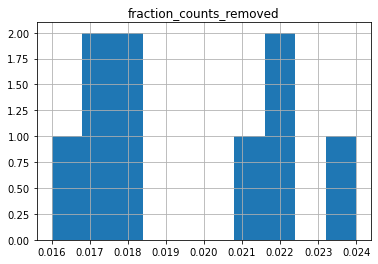

In [8]:
metrics = []
for sample in sample_loc_bal["sample_name"]:
  _ = pd.read_csv("data/01-raw/02-cellBenderOutput-ambientRNA/" + sample + "/cellbender_output_metrics.csv",
                  header = None, names = ["Metric", "Value"]).set_index("Metric").T

  _["Sample"] = sample
  metrics.append(_)

metrics = pd.concat(metrics).reset_index()
metrics.hist("fraction_counts_removed")
plt.show()

# Load adatas

In [19]:
def load_metadata(meta, keys):
    return {key: pd.Series(meta[key].values, index=meta['gwccg_research_id']).to_dict() for key in keys}

def update_obs_with_metadata(adata, meta):
    metadata_keys = [
        'disease_final', 'sex', 'age_at_sampling',
        'antifibrotics', 'immunosuppression',
        'telomere_length', 'smoking_0_ex1_current2'
    ]

    # Create a mapping from gwccg_research_id to metadata
    meta_mapping = {row['gwccg_research_id']: row for _, row in meta.iterrows()}

    # Initialize new columns in adata.obs with NaN
    for key in metadata_keys:
        adata.obs[key] = np.nan

    # Update adata.obs with metadata
    for sample in adata.obs['Sample']:
        if sample in meta_mapping:
            for key in metadata_keys:
                adata.obs.at[sample, key] = meta_mapping[sample][key]

def process_doublet_barcodes(adata, sample, is_bal):
    data_dir = "data/01-raw/01-demultiplexed/"
    doublet_barcodes = pd.read_csv(f"{data_dir}{sample}/combined_results_w_combined_assignments.tsv", delimiter="\t")
    doublet_barcodes = doublet_barcodes[doublet_barcodes['Barcode'].isin(adata.obs.index)].copy()

    adata = adata[doublet_barcodes['Barcode']].copy()


    # Assign Sample based on is_bal condition
    if is_bal:
        adata.obs['Sample'] = sample
    else:
        adata.obs['Sample'] = doublet_barcodes['MajoritySinglet_Individual_Assignment'].str.replace("0_", "").str.replace("-", "_").values

    adata.obs['Doublet'] = doublet_barcodes['MajoritySinglet_DropletType'].values
    adata.obs['Barcode'] = adata.obs.index
    adata.obs = adata.obs.set_index('Sample', drop=False)

    return adata, doublet_barcodes

def update_sample_names(adata, bal_mapping):
    for i, sampleName in enumerate(adata.obs['Sample']):
        if sampleName not in ['doublet', 'unassigned']:
            if 'P' in sampleName:
                row_index, col_index = np.where(bal_mapping == sampleName)
                if col_index.size > 0:  # Check if col_index is not empty
                    if col_index[0] == 1:
                        adata.obs['Sample'].iat[i] = bal_mapping.iloc[row_index[0], 2]
                    else:
                        adata.obs['Sample'].iat[i] = bal_mapping.iloc[row_index[0], 0]


def load_adata(sample, location, bal_mapping, meta):
    print(f'Processing Sample: {sample}')

    # Importing Data
    adata = sc.read_10x_h5(location)

    # Initialize obs with sample information
    adata.obs['Sample'] = sample
    adata.obs['Pool'] = sample

    is_bal = "BAL_" in sample
    adata, doublet_barcodes = process_doublet_barcodes(adata, sample, is_bal)

    # Update obs with metadata
    update_obs_with_metadata(adata, meta)

    adata.obs['10X_chemistry'] = "v2" if is_bal else "v3"

    # Set unique index based on condition for each row
    adata.obs['new_index'] = adata.obs['Barcode'] + '-' + adata.obs['Sample'] + (('-' + adata.obs['disease_final']).where(adata.obs['disease_final'].notna(), ''))

    adata.obs = adata.obs.set_index('new_index')

    if not is_bal:
        update_sample_names(adata, bal_mapping)


    # Subset adata to only include samples that match meta['gwccg_research_id']
    adata = adata[adata.obs['Sample'].isin(meta['gwccg_research_id'])].copy()

    return adata

In [20]:
adatas = [load_adata(sample_loc_bal.sample_name[s], sample_loc_bal.location[s], bal_mapping, meta) for s in range(len(sample_loc_bal))]

Processing Sample: RZ725_Pool4


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing Sample: RZ725_Pool5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing Sample: RZ734_Pool_1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing Sample: RZ734_Pool_2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing Sample: RZ734_Pool_3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing Sample: BAL_scRNA_Sample10


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing Sample: BAL_scRNA_Sample15


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing Sample: BAL_scRNA_Sample18


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Processing Sample: BAL_scRNA_Sample3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# First-pass Quality Control

In [21]:
def qc(adata):
  sc.pp.filter_cells(adata, min_genes = 200) # low threshold
  adata.var["mt"] = adata.var_names.str.startswith("MT-")
  adata.var["ribo"] = adata.var_names.str.startswith("RPS", "RPL")
  adata.var["hb"] = adata.var_names.str.startswith("^HB[^(P)]")

  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

  remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo',
          'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb']

  adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]

  return adata

In [22]:
adatas = [qc(ad) for ad in adatas]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/scratch/ei56/pa3687/ild-pathwayAnalysis-bal-scRNA/venv/lib64/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels import robust

# Define variables for plotting
plots = ['pct_counts_mt', 'n_genes', 'pct_counts_in_top_20_genes', 'log1p_total_counts']
sample_types = ['RZ', 'BAL']

# Combine data from all adatas into a single DataFrame
all_data = pd.concat([x.obs for x in adatas])

# Set a minimalistic seaborn style to mimic ggplot aesthetics
sns.set_theme(style="whitegrid")

# Generate density plots for each specified variable
for plot in plots:
    # Create a FacetGrid for visualizing the data
    g = sns.FacetGrid(all_data, hue="Sample", aspect=5, height=3, palette="Set1")

    # Plot the kernel density estimate (KDE)
    g.map(sns.kdeplot, plot, fill=True, alpha=0.6, linewidth=1.5)

    # Add a horizontal line at y=0 for reference
    g.map(plt.axhline, y=0, lw=1, color='black')

    # Adjust the layout of the subplots
    g.figure.subplots_adjust(hspace=0.3)

    # Set plot limits for specific variables
    if plot == 'pct_counts_mt':
        g.set(xlim=(-25, 100))
    elif plot == 'n_genes':
        g.set(xlim=(0, 8000))

    # Customize the appearance of the plots
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # Add a legend for the sample types
    g.add_legend(title="Sample", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Calculate median and 5 Median Absolute Deviations (MAD)
    mad_value = robust.mad(all_data[plot])
    median_value = all_data[plot].median()

    # Add vertical lines representing ±5 MADs
    for ax in g.axes.flat:
        ax.axvline(x=median_value + 5 * mad_value, color='red', linestyle='--', label='+5 MAD')
        ax.axvline(x=median_value - 5 * mad_value, color='red', linestyle='--', label='-5 MAD')

    # Save the figure with a high resolution
    plt.tight_layout()
    plt.savefig(f'reports/figures/qc_{plot}_combined.png', dpi=800)
    plt.close()


# Preprocessing (Removing Doublets & Unassigned)

In [30]:
from scipy.stats import median_abs_deviation as mad

def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]

    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))

    return (M > np.median(M) + nmads * mad(M))

def pp(adata):

  if adata.obs.Doublet.isin(['doublet']).any():
    adata.uns['doublets_removed'] = adata.obs.Doublet.value_counts()['doublet']
    adata = adata[adata.obs.Doublet == 'singlet']

  if adata.obs.Sample.isin(['unassigned']).any():
    adata.uns['unassigned_removed'] = adata.obs.Sample.value_counts()['unassigned']
    adata = adata[adata.obs.Sample != 'unassigned']

  if adata.obs.disease_final.isna().any():
    adata.uns['missing_metadata'] = adata.obs.DX.isna().sum()
    adata = adata[adata.obs.DX.notnull()]

  adata = adata[adata.obs.pct_counts_mt < 25] #you can lower this based on the overal distribution of your dataset

  bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
          mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
          mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
          mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
  adata = adata[~bool_vector]

  adata.uns['cells_removed'] = sum(bool_vector)

  return adata

In [31]:
adatas = [pp(ad) for ad in adatas]

Trying to set attribute `._uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `._uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `._uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `._uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `._uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Var

In [33]:
## Print how many cells in each category
for adata in adatas:
  print(adata.obs.Pool[0])
  print("\tCells removed (QC): " + str(adata.uns['cells_removed']))

  if adata.uns.get('doublets_removed') is not None:
    print("\tDoublets removed: " + str(adata.uns['doublets_removed']))

  if adata.uns.get('unassigned_removed') is not None:
    print("\tUnassigned removed: " + str(adata.uns['unassigned_removed']))

  if adata.uns.get('missing_metadata') is not None:
    print("\tMissing Metadata removed: " + str(adata.uns['missing_metadata']))

  print("\tCells Remaining: " + str(len(adata)))

RZ725_Pool4
	Cells removed (QC): 2473
	Cells Remaining: 13183
RZ725_Pool5
	Cells removed (QC): 1928
	Cells Remaining: 15118
RZ734_Pool_1
	Cells removed (QC): 1650
	Cells Remaining: 10283
RZ734_Pool_2
	Cells removed (QC): 1947
	Cells Remaining: 10905
RZ734_Pool_3
	Cells removed (QC): 1726
	Cells Remaining: 13326
BAL_scRNA_Sample10
	Cells removed (QC): 1425
	Doublets removed: 1156
	Cells Remaining: 7895
BAL_scRNA_Sample15
	Cells removed (QC): 1630
	Doublets removed: 1205
	Cells Remaining: 7966
BAL_scRNA_Sample18
	Cells removed (QC): 1167
	Doublets removed: 1325
	Cells Remaining: 7616
BAL_scRNA_Sample3
	Cells removed (QC): 1535
	Doublets removed: 907
	Cells Remaining: 7691


# Save each adata for annotation & integration

In [35]:
for adata in adatas:
    pool = adata.obs.Pool[0]
    adata.write_h5ad('data/02-preprocessed/individual-adatas/' + pool + '.h5ad')

... storing 'Sample' as categorical
... storing 'Pool' as categorical
... storing 'Doublet' as categorical
... storing 'disease_final' as categorical
... storing 'sex' as categorical
... storing 'age_at_sampling' as categorical
... storing 'antifibrotics' as categorical
... storing 'immunosuppression' as categorical
... storing 'telomere_length' as categorical
... storing 'smoking_0_ex1_current2' as categorical
... storing '10X_chemistry' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'Sample' as categorical
... storing 'Pool' as categorical
... storing 'Doublet' as categorical
... storing 'disease_final' as categorical
... storing 'sex' as categorical
... storing 'age_at_sampling' as categorical
... storing 'antifibrotics' as categorical
... storing 'immunosuppression' as categorical
... storing 'telomere_length' as categorical
... storing 'smoking_0_ex1_current2' as categorical
... storing '10X_chemistry' as categorical
... s